# **Exploratory Data Analysis For Fair Use Cases Data**

**BA820 - Project Milestone 2**

**Team:** B1 Team 13

**Team Members:** Rita Feng

# Introduction

This notebook analyzes a public dataset of U.S. fair use decisions from the U.S. Copyright Office Fair Use Index. Each case includes structured attributes (e.g., court, jurisdiction, year, and content categories) and narrative text describing the facts, legal issue, and holding, along with an indicator for whether fair use was found. I focus on the fact-based precedent finder domain: given a new dispute, how can we surface past cases with similar factual structure to support faster legal triage and case filtering.

Compared with earlier exploratory work, this analysis shifts toward case-level structure category composition, changes over time, venue/court patterns, and narrative length/complexity, because these features directly shape similarity and retrieval quality. I also apply an unsupervised clustering approach (K-means) to group cases into fact-pattern archetypes using a combination of structured and text-derived features, then interpret how clusters differ by venue, era, and outcome rates. The goal is not to “predict” outcomes, but to show how clustering + interpretable EDA can reveal repeatable patterns that make precedent search more targeted and practical.


# Setting Up

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

# Data Importing, Inspection and Preparation

## Data Importing

In [159]:
fair_use_cases = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-08-29/fair_use_cases.csv')
fair_use_findings = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-08-29/fair_use_findings.csv')

## Data Inspection

### Fair Use Cases Table

The `fair_use_cases` table provides one row per case with structured metadata such as year, court, jurisdiction, content categories, and a binary indicator for whether fair use was found. Inspection focuses on confirming completeness, consistency of categorical fields, and suitability for comparing outcomes across courts, categories, and time.

| variable       | class     | description                                                                                                   |
| -------------- | --------- | ------------------------------------------------------------------------------------------------------------- |
| case           | character | The name and number of the case.                                                                              |
| year           | integer   | The year in which the case was decided.                                                                       |
| court          | character | The court in which the ruling was made.                                                                       |
| jurisdiction   | character | The jurisdiction of that court.                                                                               |
| categories     | character | A comma- or semicolon-separated list of categories to which the case belongs. These have not been normalized. |
| outcome        | character | A string describing the outcome of the case.                                                                  |
| fair_use_found | logical   | Whether fair use was found by the court. FALSE might sometimes indicate a more complicated finding.           |

In [160]:
print("Dataset Info:")
print(fair_use_cases.info())

print("\nFirst 5 rows:")
print(fair_use_cases.head())

print("\nMissing Values:")
print(fair_use_cases.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   case            251 non-null    object
 1   year            251 non-null    int64 
 2   court           251 non-null    object
 3   jurisdiction    251 non-null    object
 4   categories      251 non-null    object
 5   outcome         251 non-null    object
 6   fair_use_found  251 non-null    bool  
dtypes: bool(1), int64(1), object(5)
memory usage: 12.1+ KB
None

First 5 rows:
                                                case  year        court  \
0  De Fontbrune v. Wofsy, 39 F.4th 1214 (9th Cir....  2022  9th Circuit   
1  Sedlik v. Von Drachenberg, No. CV 21-1102 (C.D...  2022    C.D. Cal.   
2  Sketchworks Indus. Strength Comedy, Inc. v. Ja...  2022     S.D.N.Y.   
3  Am. Soc'y for Testing & Materials v. Public.Re...  2022       D.D.C.   
4  Yang v. Mic Network Inc., No

### Fair Use Findings Table

The `fair_use_findings` table contains complementary case-level text, including summaries of key facts, legal issues, holdings, and descriptive tags. Inspection centers on text completeness and variability, as these fields support later analysis of language patterns, similarity, and thematic structure across cases.

| variable    | class     | description                                                                            |
| ----------- | --------- | -------------------------------------------------------------------------------------- |
| title       | character | The title of the case.                                                                 |
| case_number | character | The case number or numbers of the case.                                                |
| year        | character | The year in which the finding was made (or findings were made).                        |
| court       | character | The court or courts involved.                                                          |
| key_facts   | character | The key facts of the case.                                                             |
| issue       | character | A brief description of the fair use issue.                                             |
| holding     | character | The decision of the court in paragraph form.                                           |
| tags        | character | Comma- or semicolon-separated tags for this case.                                      |
| outcome     | character | A brief description of the outcome of the case. These fields have not been normalized. |

In [161]:
print("Dataset Info:")
print(fair_use_findings.info())

print("\nFirst 5 rows:")
print(fair_use_findings.head())

print("\nMissing Values:")
print(fair_use_findings.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        251 non-null    object
 1   case_number  251 non-null    object
 2   year         251 non-null    object
 3   court        251 non-null    object
 4   key_facts    251 non-null    object
 5   issue        251 non-null    object
 6   holding      251 non-null    object
 7   tags         251 non-null    object
 8   outcome      251 non-null    object
dtypes: object(9)
memory usage: 17.8+ KB
None

First 5 rows:
                                               title  \
0                              De Fontbrune v. Wofsy   
1                          Sedlik v. Von Drachenberg   
2  Sketchworks Indus. Strength Comedy, Inc. v. Ja...   
3  Am. Soc'y for Testing & Materials v. Public.Re...   
4                           Yang v. Mic Network Inc.   

                                 

## Preparing Data

The two files describe the same set of cases, but our first merge produced a low match rate because the case strings are formatted differently across the datasets, so an exact join on the original case column often fails. To improve matching, we extract the case title (the text before the first comma) from the case field, standardize it into a new `title_key`, and then merge the datasets using `title_key` and `year` as the join keys.

In [162]:
import pandas as pd
import re

def norm_title(s: str) -> str:
    if pd.isna(s):
        return ""
    s = str(s).strip().lower()
    s = s.replace("’", "'").replace("‘", "'").replace("–", "-").replace("—", "-")
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^a-z0-9 ]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

cases = fair_use_cases.copy()
findings = fair_use_findings.copy()

cases["title"] = cases["case"].astype(str).str.split(",", n=1).str[0].str.strip()

cases["title_key"] = cases["title"].map(norm_title)
findings["title_key"] = findings["title"].map(norm_title)


cases["year"] = pd.to_numeric(cases["year"], errors="coerce")
findings["year"] = pd.to_numeric(findings["year"], errors="coerce")

merged_fair_use = findings.merge(
    cases,
    on=["title_key", "year"],
    how="left",
    indicator=True,
    validate="one_to_one",
    suffixes=("_finding", "_cases")
)

matched = (merged_fair_use["_merge"] == "both").sum()
total = len(merged_fair_use)
print(f"Matched rows: {matched} / {total} ({matched/total:.1%})")


unmatched = merged_fair_use.loc[
    merged_fair_use["_merge"] == "left_only",
    ["title_finding", "case_number", "year", "court_finding"]
].head(10)

print("\nUnmatched examples (first 10):")
print(unmatched.to_string(index=False))

Matched rows: 91 / 251 (36.3%)

Unmatched examples (first 10):
                                                       title_finding                                                                       case_number   year                                                      court_finding
                  Sketchworks Indus. Strength Comedy, Inc. v. Jacobs        No. 19-CV-7470-LTS-VF, 2022 U.S. Dist. LEXIS 86331 (S.D.N.Y. May 12, 2022) 2022.0 United States District Court for the Southern District of New York
      Am. Soc'y for Testing & Materials v. Public.Resource.Org, Inc.          No. 13-cv-1215 (TSC), 2022 U.S. Dist. LEXIS 60922 (D.D.C. Mar. 31, 2022) 2022.0          United States District Court for the District of Columbia
                                    Easter Unlimited, Inc. v. Rozier            No. 18-cv-06637, 2021 U.S. Dist. LEXIS 184636 (E.D.N.Y. Sep. 17, 2021) 2021.0           U.S. District Court for the Eastern District of New York
           Andy Warhol Found. for the

In [163]:
merged_fair_use.head()

,title_finding,case_number,year,court_finding,key_facts,issue,holding,tags,outcome_finding,title_key,case,court_cases,jurisdiction,categories,outcome_cases,fair_use_found,title_cases,_merge
0,De Fontbrune v. Wofsy,39 F.4th 1214 (9th Cir. 2022),2022.0,United States Court of Appeals for the Ninth C...,Plaintiffs own the rights to a catalogue compr...,Whether reproduction of photographs documentin...,"The panel held that the first factor, the purp...",Education/Scholarship/Research; Photograph,Fair use not found,de fontbrune v wofsy,"De Fontbrune v. Wofsy, 39 F.4th 1214 (9th Cir....",9th Circuit,9th Circuit,Education/Scholarship/Research; Photograph,Fair use not found,False,De Fontbrune v. Wofsy,both
1,Sedlik v. Von Drachenberg,"No. CV 21-1102, 2022 WL 2784818 (C.D. Cal. May...",2022.0,United States District Court for the Southern ...,Plaintiff Jeffrey Sedlik is a photographer who...,Whether use of a photograph as the reference i...,"Considering the first fair use factor, the pur...",Painting/Drawing/Graphic; Photograph,Preliminary finding; Fair use not found,sedlik v von drachenberg,"Sedlik v. Von Drachenberg, No. CV 21-1102 (C.D...",C.D. Cal.,9th Circuit,Painting/Drawing/Graphic; Photograph,Preliminary finding; Fair use not found,False,Sedlik v. Von Drachenberg,both
2,"Sketchworks Indus. Strength Comedy, Inc. v. Ja...","No. 19-CV-7470-LTS-VF, 2022 U.S. Dist. LEXIS 8...",2022.0,United States District Court for the Southern ...,Plaintiff Sketchworks Industrial Strength Come...,"Whether the use of protected elements, includi...","The court found that the first factor, the pur...",Film/Audiovisual; Music; Parody/Satire; Review...,Fair use found,sketchworks indus strength comedy inc v jacobs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,Am. Soc'y for Testing & Materials v. Public.Re...,"No. 13-cv-1215 (TSC), 2022 U.S. Dist. LEXIS 60...",2022.0,United States District Court for the District ...,"Defendant Public.Resource.Org, Inc., a non-pro...",Whether it is fair use to make available onlin...,"As directed by the court of appeals, the distr...",Education/Scholarship/Research; Textual Work; ...,Mixed Result,am soc y for testing materials v public resour...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,Yang v. Mic Network Inc.,"Nos. 20-4097-cv(L), 20-4201-cv (XAP), 2022 U.S...",2022.0,United States Court of Appeals for the Second ...,Plaintiff Stephen Yang (“Yang”) licensed a pho...,"Whether using a screenshot from an article, in...","On appeal, the court decided that the first fa...",News Reporting; Photography,Fair use found,yang v mic network inc,"Yang v. Mic Network Inc., Nos. 20-4097-cv, 20-...",2d Circuit,2nd Circuit,News reporting; Photography,Fair use found,True,Yang v. Mic Network Inc.,both


Now we achieve a higher match rate of about 35.12%, up from 12% in our initial attempt,an improvement of roughly 23 percentage points (nearly 3× higher). Given the time and tooling constraints, we will use this merged table for the remainder of the EDA and the K-means analysis.

# Exploratory Data Analysis (EDA)

This EDA analyzes the three tables in their original form. `fair_use_cases `provides structured metadata (e.g., year, court, jurisdiction, categories, outcome, and fair_use_found), while `fair_use_findings` contributes richer narrative fields (e.g., key_facts, issue, holding) and tags. For analyses that require findings-only text or outcome-linked narrative—such as fact-text exploration and clustering—we use the `merged_file` created from our join.

## Part 1: Risk by Category

Because this project is a precedent finder, we want to identify which categories tend to be higher risk. We compare fair-use win rates across categories to understand which types of cases are less likely to succeed and therefore may require more caution during triage.

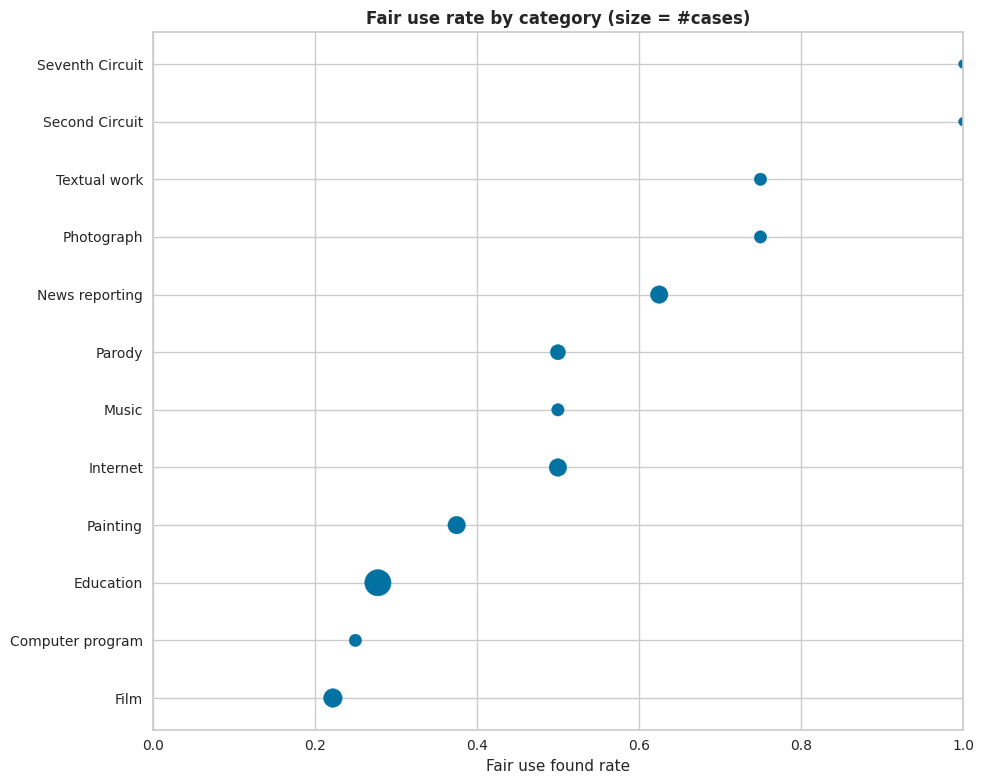

In [164]:
merged_fair_use["fair_use_found_bool"] = merged_fair_use["fair_use_found"].map(
    {"TRUE": True, "FALSE": False, True: True, False: False}
)

df = merged_fair_use.dropna(subset=["fair_use_found_bool"]).copy()
df["fair_use_found_num"] = df["fair_use_found_bool"].astype(int)

df["primary_category"] = (
    df["categories"].fillna("").astype(str)
      .str.split(";", n=1).str[0]
      .str.split("/", n=1).str[0]
      .str.strip()
)
df.loc[df["primary_category"] == "", "primary_category"] = np.nan
df = df.dropna(subset=["primary_category"])


cat_stats = (df.groupby("primary_category")["fair_use_found_num"]
    .agg(n_cases="size", success_rate="mean")
    .reset_index()
)

cat_stats = cat_stats[cat_stats["n_cases"] >= 2].sort_values("success_rate")


plt.figure(figsize=(10, 8))
plt.scatter(cat_stats["success_rate"], cat_stats["primary_category"], s=cat_stats["n_cases"] * 20)
plt.xlim(0, 1)
plt.xlabel("Fair use found rate")
plt.ylabel("")
plt.title("Fair use rate by category (size = #cases)", fontweight="bold")
plt.tight_layout()
plt.show()



The graph shows how fair-use outcomes vary across different category contexts. The x-axis represents the fair-use found rate, and the size of each point reflects the number of cases in that category. For example, News reporting appears further to the right and has a relatively large marker, suggesting a higher win rate and a more reliable estimate because it is supported by more samples. In contrast, categories such as Education/Scholarship/Research and Film/Audiovisual lie further to the left, indicating lower fair-use win rates.

However, two labels, Second Circuit and Seventh Circuit, appear among the top “categories,” even though they are courts rather than content categories. This suggests there are data-cleaning issues (e.g., court/jurisdiction values mixed into the category field), and the category column needs additional cleaning before the results can be fully trusted.

## Part 2: Fact Complexity

We use a histogram to show the distribution of word counts in the case facts. By comparing the fair use found vs. not found groups, the plot provides insight into whether cases with longer (or shorter) fact descriptions are associated with different outcomes.

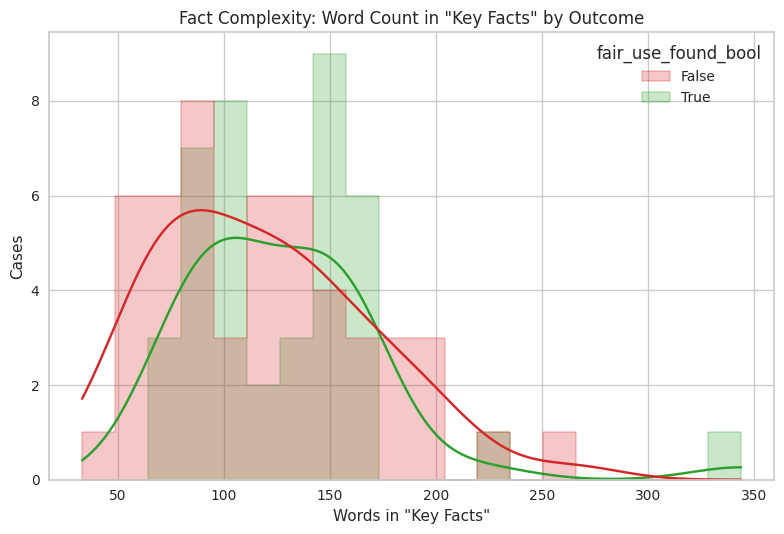

In [165]:
merged_fair_use["fact_length"] = merged_fair_use["key_facts"].fillna("").astype(str).str.split().str.len()

sns.histplot(
    data=merged_fair_use.dropna(subset=["fair_use_found_bool"]),
    x="fact_length", hue="fair_use_found_bool",
    bins=20, element="step", kde=True,
    palette={True: "tab:green", False: "tab:red"},
    common_norm=False
)

plt.title('Fact Complexity: Word Count in "Key Facts" by Outcome')
plt.xlabel('Words in "Key Facts"')
plt.ylabel("Cases")
plt.tight_layout()
plt.show()


According to the histogram, the green (fair use found) and red (fair use not found) distributions overlap substantially. However, the green distribution were slightly shifted to the right, suggesting that cases where fair use is found tend to involve longer “key facts” descriptions, possibly reflecting that courts consider more detailed factual context or evidence in successful fair use decisions.

However, the two distributions still overlap heavily, so fact length alone is not a strong predictor of success.

## Part 3: Temporal Trends

This section looks at Line Chart: Legal Volume Over Time.

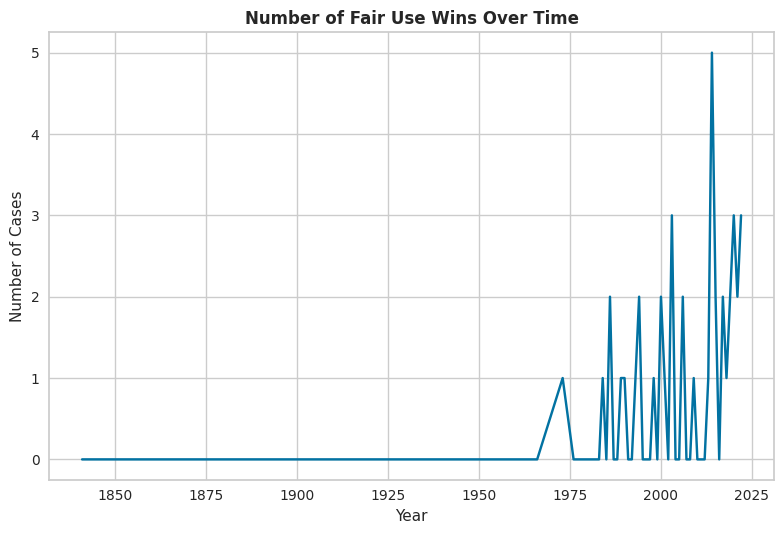

In [166]:
merged_fair_use["win"] = merged_fair_use["fair_use_found"].map({"TRUE": 1, "FALSE": 0, True: 1, False: 0})
wins_per_year = merged_fair_use.groupby("year")["win"].sum()

sns.lineplot(x=wins_per_year.index, y=wins_per_year.values)
plt.title("Number of Fair Use Wins Over Time", fontweight="bold")
plt.xlabel("Year")
plt.ylabel("Number of Cases")
plt.tight_layout()
plt.show()


Fair use rates by year are very noisy, especially in earlier years, which suggests many years have only a few cases and year-by-year conclusions should be cautious.

## Part 4: Court Bias

Finally, we examine potential court-level differences to understand which courts have higher fair-use success rates and whether outcomes vary systematically across jurisdictions.

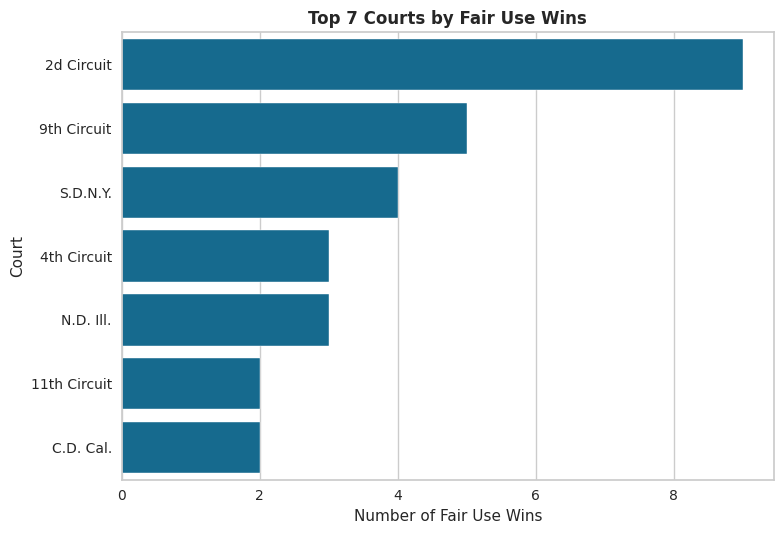

In [169]:
merged_fair_use["win"] = merged_fair_use["fair_use_found"].map({"TRUE": 1, "FALSE": 0, True: 1, False: 0})

top7_wins = merged_fair_use.groupby("court_cases")["win"].sum().sort_values(ascending=False).head(7)

sns.barplot(x=top7_wins.values, y=top7_wins.index)
plt.title("Top 7 Courts by Fair Use Wins", fontweight="bold")
plt.xlabel("Number of Fair Use Wins")
plt.ylabel("Court")
plt.tight_layout()
plt.show()


According to the graph, 2d Circuit has the highest number of fair-use win cases. However, the total number of cases is only around 9, so given the small size of our merged dataset, this result should be interpreted with caution.

# K-Means Model

# Prepare Data

We then move on to an unsupervised machine learning approach. Based on our EDA, we focus on four key features: category, court, text length, and year. The first step is to extract these variables from the dataset and prepare them for clustering.

In [172]:
df = merged_fair_use.copy()
df["category_k"] = (
    df["categories"].fillna("").astype(str)
      .str.split(";", n=1).str[0]
      .str.split("/", n=1).str[0]
      .str.strip()
)
merged_fair_use["court_k"] = merged_fair_use["court_cases"].fillna("Unknown").astype(str).str.strip()
df["text_len_k"] = df["key_facts"].fillna("").astype(str).str.split().str.len()
df["year_k"] = pd.to_numeric(df["year"], errors="coerce")
X = df[["category_k", "court_k", "text_len_k", "year_k"]].copy()
X = X.dropna(subset=["court_k", "year_k"])
X = X[X["category_k"] != ""]

We treat text length and year as numerical features, and category and court as categorical features. To use them in K-means, we apply one-hot encoding to convert the categorical variables into numeric vectors, enabling the clustering model to process all four features.

In [173]:
cat_cols = ["category_k", "court_k"]
num_cols = ["text_len_k", "year_k"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ]
)


X_mat = preprocess.fit_transform(X)

Because one-hot encoded data is usually stored as a sparse matrix, some tools may not recognize it and can throw errors. In this step, we convert it into a normal 2-D numeric array so the clustering and visualization steps can run smoothly.

In [176]:
import numpy as np
from scipy import sparse

if sparse.issparse(X_mat):
    X_mat = X_mat.toarray()

X_mat = np.asarray(X_mat, dtype=float)

print(type(X_mat), X_mat.shape, X_mat.dtype)
visualizer.fit(X_mat)
visualizer.show();

<class 'numpy.ndarray'> (91, 60) float64


# Elbow

Once the data is properly prepared, we use the elbow method to determine a reasonable value of k (the number of clusters).

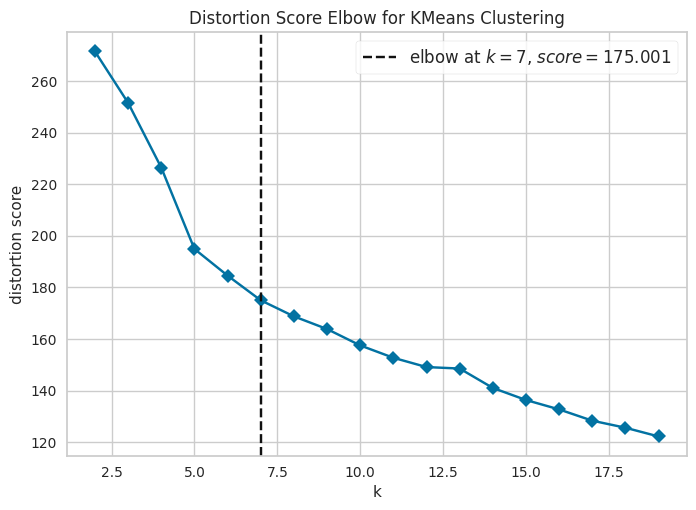

In [177]:
from sklearn.cluster import KMeans
from scipy import sparse
from yellowbrick.cluster import KElbowVisualizer
if sparse.issparse(X_mat):
    X_mat = X_mat.toarray()
else:
    X_mat = np.asarray(X_mat)
clustering = KMeans(random_state=42)
visualizer = KElbowVisualizer(clustering, k=(2, 20), metric="distortion", timings=False)
X_mat = np.asarray(X_mat)
visualizer.fit(X_mat)
visualizer.show();

Based on the elbow plot, the distortion curve begins to flatten around **k ≈ 7** (about 7–7.5), so **k = 7** is a reasonable choice to use.


# Silhouette

Because the elbow method cannot tell us whether choosing k = 7 actually separates the clusters well, we use the silhouette score to evaluate the quality of the clustering. The silhouette plot shows how well each point fits within its assigned cluster and how distinct the clusters are overall, helping us judge whether the clusters are clearly separated or heavily overlapping.

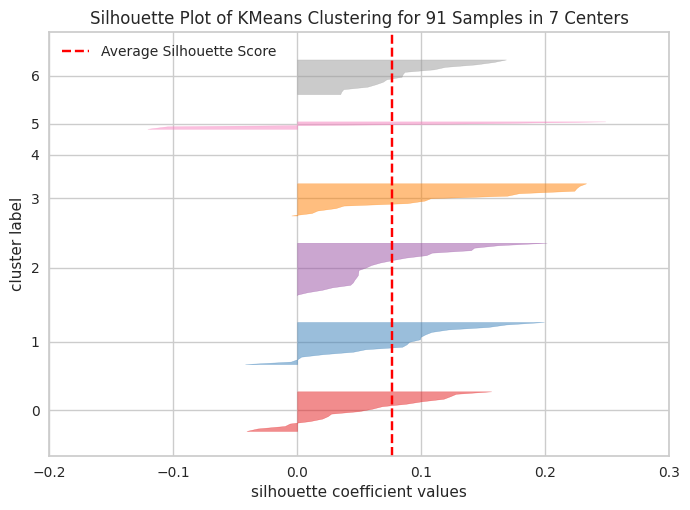

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 91 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [178]:
from yellowbrick.cluster import SilhouetteVisualizer

k = 7
kmeans_model = KMeans(n_clusters=k, random_state=42)
viz = SilhouetteVisualizer(kmeans_model, timings=False)
viz.fit(X_mat)
viz.show()

Based on the silhouette plot, the average silhouette score is around 0.08, which is relatively low. This suggests that using category, court, text length, and year as features leads to clusters that overlap substantially rather than forming clearly separated groups.

# K-means clustering

Now we run the actual K-means clustering method. The algorithm assigns each case to the nearest cluster centroid, and we then count how many cases fall into each cluster.

In [179]:
kmeans = KMeans(n_clusters=k, random_state=42)
X["cluster_labels"] = kmeans.fit_predict(X_mat).astype(str)

print(X["cluster_labels"].value_counts())

cluster_labels
2    22
1    18
0    17
6    15
3    14
5     4
4     1
Name: count, dtype: int64


According to the results, Cluster 2 contains the most cases (22). In contrast, Cluster 4 has only one case, which likely indicates an outlier or that the model is splitting the data too finely.

We then take a deeper look at each cluster to understand its key characteristics and what types of cases it represents.

In [181]:
cluster_profile = (
    X.groupby("cluster_labels")
     .agg(
         n_cases=("cluster_labels", "size"),
         avg_text_len=("text_len_k", "mean"),
         avg_year=("year_k", "mean"),
         top_category=("category_k", lambda s: s.mode().iat[0]),
         top_court=("court_k", lambda s: s.mode().iat[0]),
     )
     .sort_values("n_cases", ascending=False)
)

cluster_profile

,n_cases,avg_text_len,avg_year,top_category,top_court
cluster_labels,,,,,
2,22,135.227273,2018.181818,Internet,S.D.N.Y.
1,18,80.333333,1991.166667,Film,9th Circuit
0,17,170.117647,2012.470588,Education,2d Circuit
6,15,83.133333,2007.133333,Painting,2d Circuit
3,14,107.571429,1983.214286,Education,2d Circuit
5,4,262.500000,2011.750000,Computer program,11th Circuit
4,1,89.000000,1841.000000,Education,C.C.D. Mass.


According to this table, Cluster 2 contains the most cases and also has one of the most recent average years compared with the other clusters. Its dominant category is Internet, and the top court is S.D.N.Y. In contrast, Cluster 4 is the smallest cluster (only one case) and shows an unusually old average year, suggesting it may be an outlier or a data-quality issue rather than a meaningful group.

# Hierachical Clustering

After running K-means, we use hierarchical clustering as a validation step to check whether it produces a similar grouping structure, and to see whether the clusters are consistent or differ significantly.

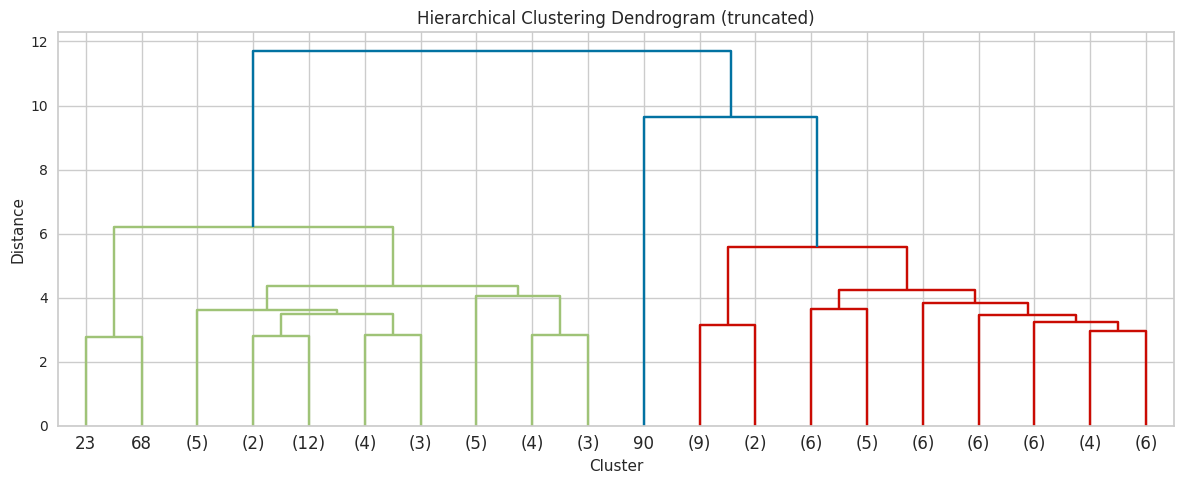

In [182]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

Z = linkage(X_mat, method="ward")

plt.figure(figsize=(12, 5))
dendrogram(Z, truncate_mode="lastp", p=20)  # show top structure
plt.title("Hierarchical Clustering Dendrogram (truncated)")
plt.xlabel("Cluster")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

According to the hierarchical clustering results, the clusters are not sharply separated; instead, the cases form a few broad groups with overlapping subgroups.

# Summary

In this project, we take a deeper look at the dataset through content category, fact-text length, court, and time (year) to support the fact-based precedent finder goal.

Category: Cases labeled as news reporting show a relatively higher fair use success rate, while education has a comparatively lower success rate in our matched sample.

Year trend: As cases become more recent, the share of successful fair use outcomes shows an upward trend.

Fact-text length: The distribution of key_facts word counts for successful cases is slightly shifted to the right, suggesting that fair use–found cases tend to include longer factual narratives.

Court: Among courts in the matched dataset, S.D.N.Y. contains the highest number of fair use–found cases.

K-means setup: We selected four features (year/decade, court, primary category, and fact-text length) that are most relevant to precedent finding and used them in a K-means clustering model. The elbow method suggested K = 7 as a reasonable choice, while the silhouette score (~0.08) indicates substantial overlap between clusters and limited separation.

Cluster results: Using 7 clusters, we found that Cluster 2 contains the largest number of cases and exhibits characteristics consistent with the earlier EDA patterns (e.g., dominant courts/categories and fact-length structure).

# Next Steps


1. Our merge rate between the two tables is only 32%. Since the dataset is already small, we cannot afford to drop more cases. The next step is to improve the join strategy so we can merge the two files with a much higher match rate while preserving as many records as possible.

2. We also found that the K-means clusters overlap heavily, which suggests our current features do not capture factual similarity well. For example, using only text length mainly measures the amount of information, but the content of the facts is often more important. We should move toward features that reflect factual structure and meaning (e.g., representations of the key-facts text), rather than just metadata.

3. We should test alternative clustering methods that are better suited for categorical-heavy data, since this precedent-finder relies more on categorical signals (category, court/jurisdiction) than purely numerical ones.

4. Finally, we can expand the feature set by adding additional legal and case-specific attributes to improve separation and interpretability of the clusters.